In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/DS340/Final Project/Sea_animals.zip'


Mounted at /content/drive


In [3]:
import zipfile
import os

extract_path = '/content/sea_animals_dataset'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)
print(os.listdir(extract_path))


Files extracted to: /content/sea_animals_dataset
['Crabs', 'Clams', 'Seahorse', 'Octopus', 'Whale', 'Lobster', 'Jelly Fish', 'Fish', 'Nudibranchs', 'Squid', 'Penguin', 'Turtle_Tortoise', 'Eel', 'Starfish', 'Corals', 'Shrimp', 'Sea Rays', 'Sharks', 'Puffers', 'Dolphin', 'Otter', 'Seal', 'Sea Urchins']


In [4]:
import os
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


In [5]:
source_dir = "/content/sea_animals_dataset"
train_dir = "/content/drive/My Drive/seadata_train"
val_dir = "/content/seadata_val"
test_dir = "/content/drive/My Drive/seadata_test"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for label in os.listdir(source_dir):
    label_path = os.path.join(source_dir, label)

    if os.path.isdir(label_path):
        images = [img for img in os.listdir(label_path) if img.endswith(('jpg', 'png', 'jpeg'))]
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
        train_label_dir = os.path.join(train_dir, label)
        test_label_dir = os.path.join(test_dir, label)
        os.makedirs(train_label_dir, exist_ok=True)
        os.makedirs(test_label_dir, exist_ok=True)

        for img in train_images:
            shutil.copy(os.path.join(label_path, img), os.path.join(train_label_dir, img))

        for img in test_images:
            shutil.copy(os.path.join(label_path, img), os.path.join(test_label_dir, img))

print("Train and test datasets created in 'seadata_train' and 'seadata_test' directories, respectively.")


Train and test datasets created in 'seadata_train' and 'seadata_test' directories, respectively.


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 8777 images belonging to 23 classes.
Found 2184 images belonging to 23 classes.
Found 2750 images belonging to 23 classes.


In [7]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

def create_model(base_model):
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet = create_model(base_model_resnet)
model_vgg = create_model(base_model_vgg)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_resnet = ModelCheckpoint(filepath='best_resnet_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
checkpoint_vgg = ModelCheckpoint(filepath='best_vgg_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

print("Training ResNet50...")
history_resnet = model_resnet.fit(
    train_generator,
    batch_size=32,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, checkpoint_resnet]
)

print("Training VGG16...")
history_vgg = model_vgg.fit(
    train_generator,
    batch_size=32,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, checkpoint_vgg]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training ResNet50...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.4601 - loss: 1.9147
Epoch 1: val_loss improved from inf to 3.40381, saving model to best_resnet_model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 289s 791ms/step - accuracy: 0.4606 - loss: 1.9128 - val_accuracy: 0.0348 - val_loss: 3.4038
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.7770 - loss: 0.7574
Epoch 2: val_loss improved from 3.40381 to 3.20606, saving model to best_resnet_model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 191s 662ms/step - accuracy: 0.7770 - loss: 0.7574 - val_accuracy: 0.1369 - val_loss: 3.2061
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8272 - loss: 0.5736
Epoch 3: val_loss improved from 3.20606 to 1.10051, saving model to best_resnet_model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 201s 660ms/step - accuracy: 0.8271 - loss: 0.5736 - val_accuracy: 0.6754 - val_loss: 1.1005
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8610 - loss: 0.4525
Epoch 4: val_loss improv

In [8]:
print("Evaluating ResNet50...")
test_loss_resnet, test_accuracy_resnet = model_resnet.evaluate(
    test_generator,
    steps=int(np.ceil(test_generator.samples / test_generator.batch_size))
)

print("Evaluating VGG16...")
test_loss_vgg, test_accuracy_vgg = model_vgg.evaluate(
    test_generator,
    steps=int(np.ceil(test_generator.samples / test_generator.batch_size))
)

print(f"ResNet50 Test Accuracy: {test_accuracy_resnet * 100:.2f}%")
print(f"VGG16 Test Accuracy: {test_accuracy_vgg * 100:.2f}%")

print("Predicting with ResNet50...")
predictions_resnet = model_resnet.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size)))
y_pred_resnet = np.argmax(predictions_resnet, axis=1)

print("Predicting with VGG16...")
predictions_vgg = model_vgg.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size)))
y_pred_vgg = np.argmax(predictions_vgg, axis=1)

Evaluating ResNet50...
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.7417 - loss: 1.0264
Evaluating VGG16...
86/86 ━━━━━━━━━━━━━━━━━━━━ 28s 320ms/step - accuracy: 0.2667 - loss: 2.4742
ResNet50 Test Accuracy: 76.62%
VGG16 Test Accuracy: 31.96%
Predicting with ResNet50...
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step
Predicting with VGG16...
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step


Classification Report for ResNet50:
                  precision    recall  f1-score   support

          Clams       0.63      0.67      0.65       100
         Corals       0.53      0.80      0.64       100
          Crabs       0.97      0.86      0.91       100
        Dolphin       0.84      0.81      0.82       157
            Eel       0.63      0.67      0.65       100
           Fish       0.65      0.43      0.52        99
     Jelly Fish       0.91      0.96      0.93       169
        Lobster       0.72      0.74      0.73       100
    Nudibranchs       0.75      0.72      0.73       100
        Octopus       0.70      0.46      0.56       113
          Otter       0.98      0.99      0.99       100
        Penguin       0.94      0.74      0.83        97
        Puffers       0.79      0.49      0.60       107
       Sea Rays       0.72      0.68      0.70       104
    Sea Urchins       0.98      0.96      0.97       116
       Seahorse       0.91      0.52      0.66    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


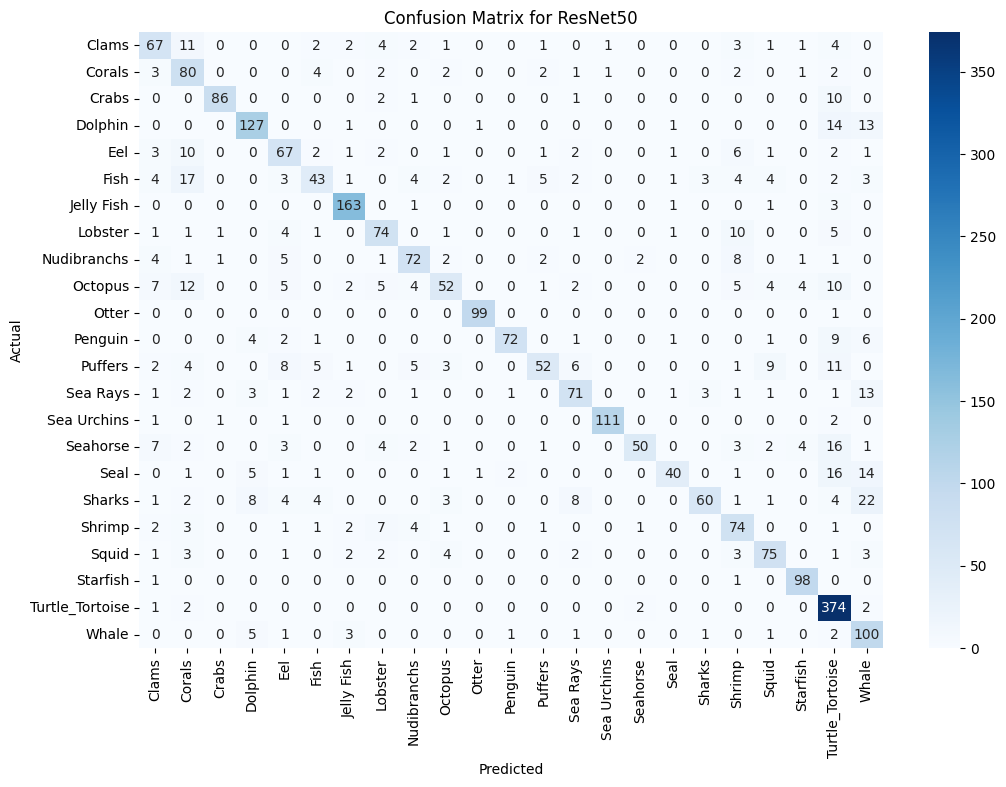

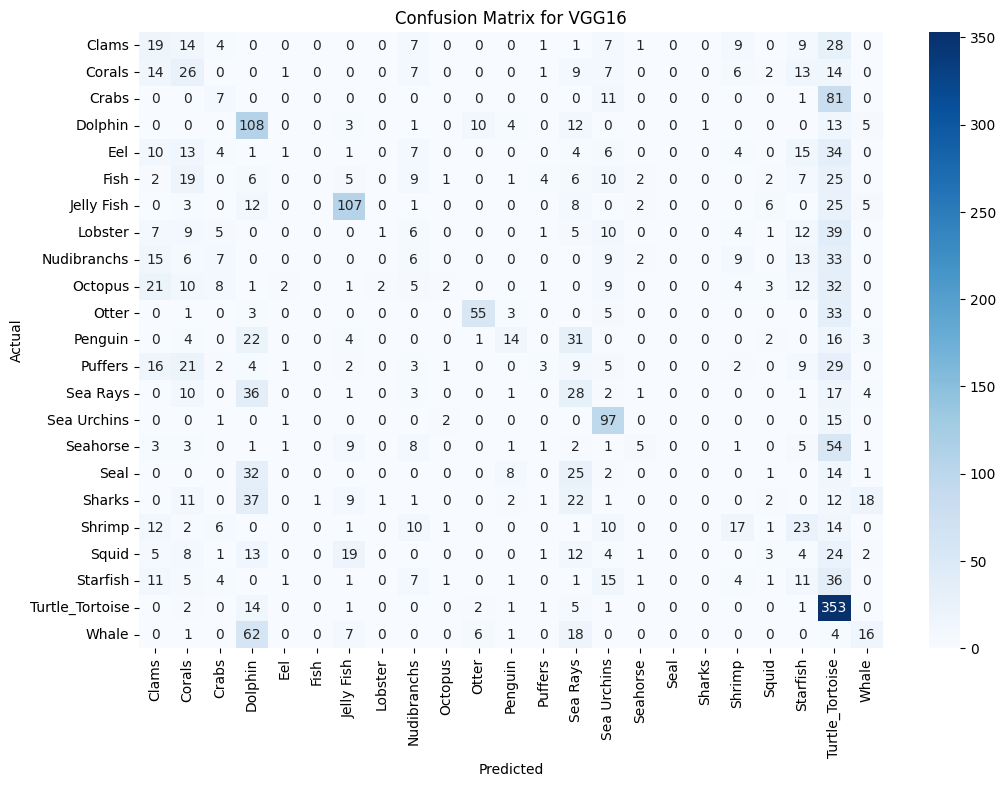

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = test_generator.classes

print("Classification Report for ResNet50:\n", classification_report(y_true, y_pred_resnet, target_names=list(test_generator.class_indices.keys())))
print("Classification Report for VGG16:\n", classification_report(y_true, y_pred_vgg, target_names=list(test_generator.class_indices.keys())))

cm_resnet = confusion_matrix(y_true, y_pred_resnet)
cm_vgg = confusion_matrix(y_true, y_pred_vgg)

plt.figure(figsize=(12, 8))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for ResNet50')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for VGG16')
plt.show()


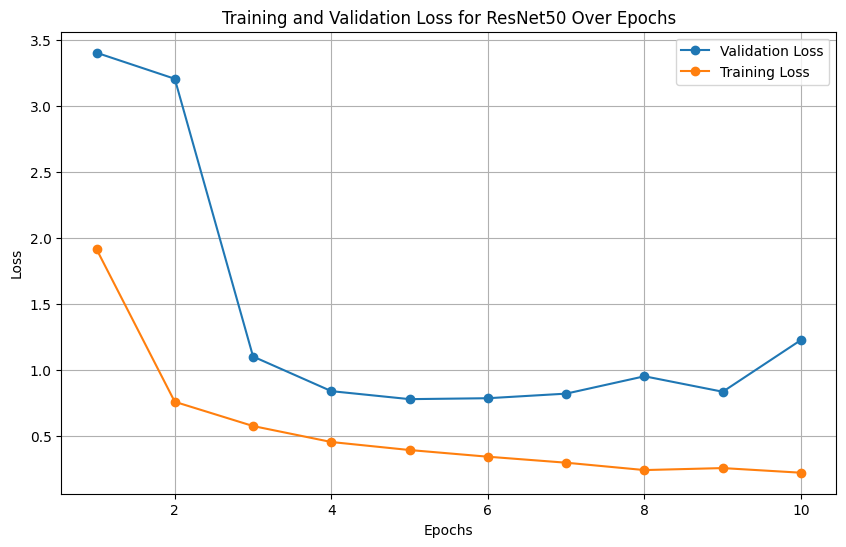

In [15]:
import matplotlib.pyplot as plt

resnet_epochs = list(range(1, 11))
resnet_train_loss = [1.9147, 0.7574, 0.5736, 0.4525, 0.3917, 0.3411, 0.2956, 0.2398, 0.2549, 0.2197]
resnet_val_loss = [3.4038, 3.2061, 1.1005, 0.8381, 0.7775, 0.7845, 0.8193, 0.9509, 0.8336, 1.2263]

plt.figure(figsize=(10, 6))
plt.plot(resnet_epochs, resnet_val_loss, label='Validation Loss', marker='o')
plt.plot(resnet_epochs, resnet_train_loss, label='Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet50 Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


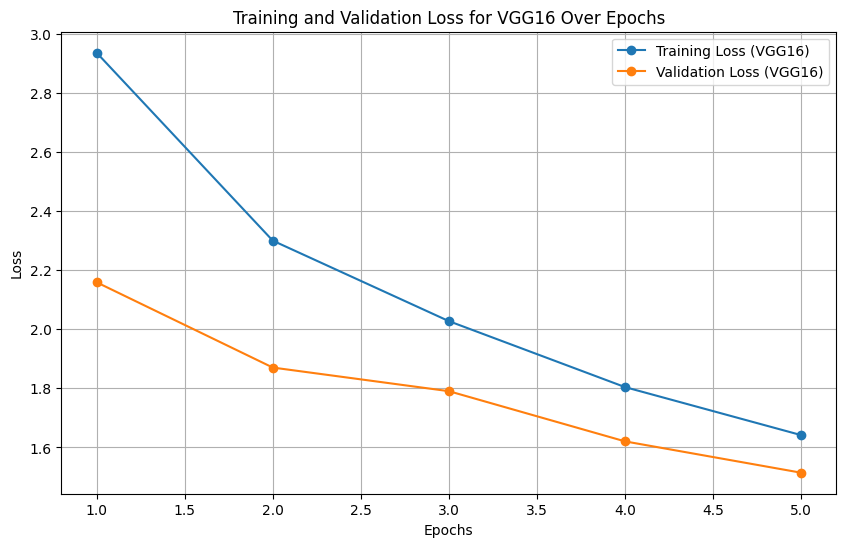

In [16]:
import matplotlib.pyplot as plt

vgg_epochs = list(range(1, 6))
vgg_train_loss = [2.9364, 2.3001, 2.0275, 1.8042, 1.6416]
vgg_val_loss = [2.1591, 1.8704, 1.7904, 1.6204, 1.5143]

plt.figure(figsize=(10, 6))
plt.plot(vgg_epochs, vgg_train_loss, label='Training Loss', marker='o')
plt.plot(vgg_epochs, vgg_val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VGG16 Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
